Лабораторная работа №5

Импортируем библиотеки

In [1]:
from matplotlib import pyplot as plt
import os
import numpy as np
import pandas as pd
from PIL import Image
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms


Извлекаем пути к изображениям из csv файла

In [2]:
dframe = pd.read_csv(
    "K:/Pyth/PLab1/Lab2/annotation.csv", delimiter=",", names=["Absolute Path", "Relative Path", "Class"]
)
img_list=dframe["Absolute Path"].tolist()
random.shuffle(img_list)
print(img_list[:5])

['K:\\Pyth\\PLab1\\dataset\\brown_bear\\0372.jpg', 'K:\\Pyth\\PLab1\\dataset\\brown_bear\\0271.jpg', 'K:\\Pyth\\PLab1\\dataset\\brown_bear\\0977.jpg', 'K:\\Pyth\\PLab1\\dataset\\brown_bear\\0204.jpg', 'K:\\Pyth\\PLab1\\dataset\\polar_bear\\0280.jpg']


Получаем метки класса

In [3]:
img_label=[]
for i in range(len(img_list)):
    img_label.append(os.path.basename(os.path.dirname(img_list[i])))
print(img_label[:5])

['brown_bear', 'brown_bear', 'brown_bear', 'brown_bear', 'polar_bear']


Разделяем список изображений на тренировочный, тестовый и валидационный

In [4]:
train_list = img_list[0 : int(len(img_list) * 0.8)]
test_list = img_list[int(len(img_list) * 0.8) : int(len(img_list) * 0.9)]
val_list = img_list[int(len(img_list) * 0.9) : int(len(img_list))]
print(len(train_list ))
print(len(test_list))
print(len(val_list))

1600
200
200


Проверяем картинки

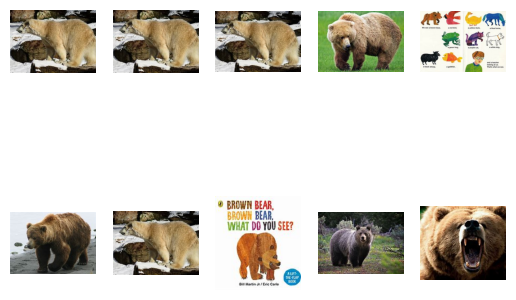

In [5]:
random_idx = np.random.randint(1,len(img_list),size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(img_list[idx])
    plt.imshow(img)
    i+=1
    plt.axis('off')


plt.show()

Определяем класс Dataset, хранящий преобразованные изображения

In [6]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform


    def __len__(self):
        return len(self.file_list)


    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = os.path.basename(os.path.dirname(img_path))
        label = 0 if label == "brown_bear" else 1
        return img_transformed, label

Пайплайн

In [7]:
fixed_transforms = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    )
train_data = Dataset(train_list, transform=fixed_transforms)
test_data = Dataset(test_list, transform=fixed_transforms)
val_data = Dataset(val_list, transform=fixed_transforms)

In [8]:
print(len(train_data))
train_data[0][0].shape

1600


torch.Size([3, 224, 224])

Класс CNN построения модели

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.fc1 = nn.Linear(3 * 3 * 16, 10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10, 2)
        self.relu = nn.ReLU()


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(1234)
if device == "cuda":
    torch.cuda.manual_seed_all(1234)
model = CNN()
model.train()

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=144, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

Отображаем графики

In [11]:
def show_results(epochs, acc, loss, v_acc, v_loss) -> None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(range(epochs), acc, color="green", label="Train accuracy")
    ax2.plot(range(epochs), loss, color="green", label="Train loss")
    ax1.plot(range(epochs), v_acc, color="blue", label="Validation accuracy")
    ax2.plot(range(epochs), v_loss, color="blue", label="Validation loss")
    ax1.legend()
    ax2.legend()
    plt.show()

In [12]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

Процесс обучения

In [13]:
def training(epochs, batch_size, lear):
    optimizer = optim.Adam(params = model.parameters(),lr=lear)
    criterion = nn.CrossEntropyLoss()
    epochs = epochs
    accuracy_values = []
    loss_values = []
    val_accuracy_values=[]
    val_loss_values=[]
    val_loader = torch.utils.data.DataLoader(dataset = val_data, 
                                            batch_size=batch_size, 
                                            shuffle=False)
    train_loader = torch.utils.data.DataLoader(dataset = train_data, 
                                            batch_size=batch_size, 
                                            shuffle=True )
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        
        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)
            
            output = model(data)
            loss = criterion(output, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            acc = ((output.argmax(dim=1) == label).float().mean())
            epoch_accuracy += acc/len(train_loader)
            epoch_loss += loss/len(train_loader)
            
        print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
        accuracy_values.append(epoch_accuracy.item())
        loss_values.append(epoch_loss.item())

        with torch.no_grad():
            epoch_val_accuracy=0
            epoch_val_loss =0
            for data, label in val_loader:
                data = data.to(device)
                label = label.to(device)
                
                val_output = model(data)
                val_loss = criterion(val_output,label)
                
                
                acc = ((val_output.argmax(dim=1) == label).float().mean())
                epoch_val_accuracy += acc/ len(val_loader)
                epoch_val_loss += val_loss/ len(val_loader)
                
            print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))
            val_accuracy_values.append(epoch_val_accuracy.item())
            val_loss_values.append(epoch_val_loss.item()) 
    show_results(epochs,accuracy_values, loss_values, val_accuracy_values, val_loss_values)

Запуск

Epoch : 1, train accuracy : 0.8918750286102295, train loss : 0.42083507776260376
Epoch : 1, val_accuracy : 0.9399999976158142, val_loss : 0.23247665166854858
Epoch : 2, train accuracy : 0.9456249475479126, train loss : 0.17611642181873322
Epoch : 2, val_accuracy : 0.9549999833106995, val_loss : 0.13651549816131592
Epoch : 3, train accuracy : 0.9631251096725464, train loss : 0.12342966347932816
Epoch : 3, val_accuracy : 0.9700000286102295, val_loss : 0.1090676560997963
Epoch : 4, train accuracy : 0.965624988079071, train loss : 0.09597931057214737
Epoch : 4, val_accuracy : 0.9650000333786011, val_loss : 0.10490790009498596
Epoch : 5, train accuracy : 0.9718748927116394, train loss : 0.08495119214057922
Epoch : 5, val_accuracy : 0.9800000190734863, val_loss : 0.08142343908548355
Epoch : 6, train accuracy : 0.9712499976158142, train loss : 0.08094935864210129
Epoch : 6, val_accuracy : 0.9750000238418579, val_loss : 0.10086921602487564
Epoch : 7, train accuracy : 0.9731249213218689, train 

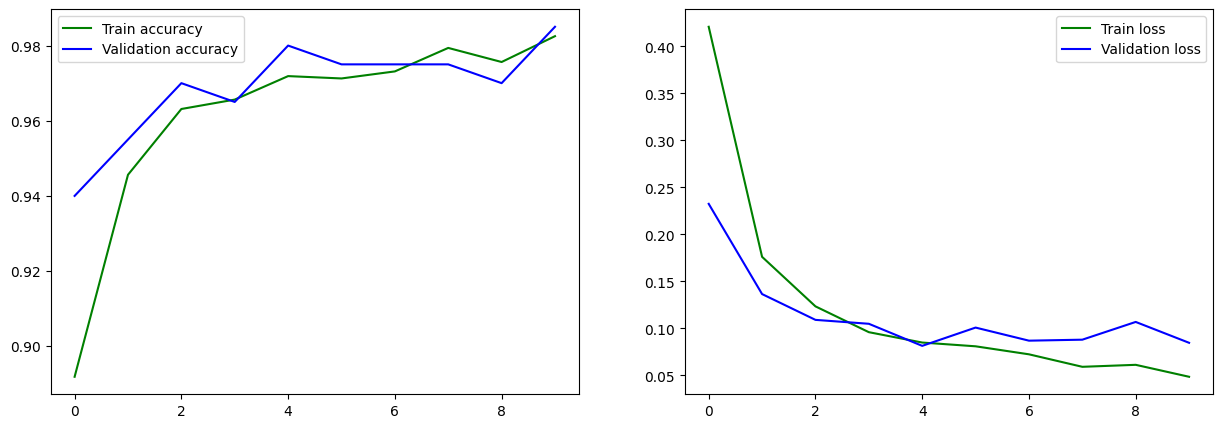

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=144, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [14]:
training(10, 100, 0.001)
model.apply(weight_reset)

Epoch : 1, train accuracy : 0.8906249403953552, train loss : 0.31329432129859924
Epoch : 1, val_accuracy : 0.9599999785423279, val_loss : 0.19368749856948853
Epoch : 2, train accuracy : 0.9618749618530273, train loss : 0.12842458486557007
Epoch : 2, val_accuracy : 0.9800000190734863, val_loss : 0.0764634907245636
Epoch : 3, train accuracy : 0.9693750143051147, train loss : 0.09431348741054535
Epoch : 3, val_accuracy : 0.9750000238418579, val_loss : 0.11145216226577759
Epoch : 4, train accuracy : 0.9793749451637268, train loss : 0.06583567708730698
Epoch : 4, val_accuracy : 0.9750000238418579, val_loss : 0.11277908086776733
Epoch : 5, train accuracy : 0.9787498712539673, train loss : 0.07290830463171005
Epoch : 5, val_accuracy : 0.9750000238418579, val_loss : 0.06371941417455673
Epoch : 6, train accuracy : 0.9774999618530273, train loss : 0.06303688883781433
Epoch : 6, val_accuracy : 0.9750000238418579, val_loss : 0.09408516436815262
Epoch : 7, train accuracy : 0.9831249117851257, train

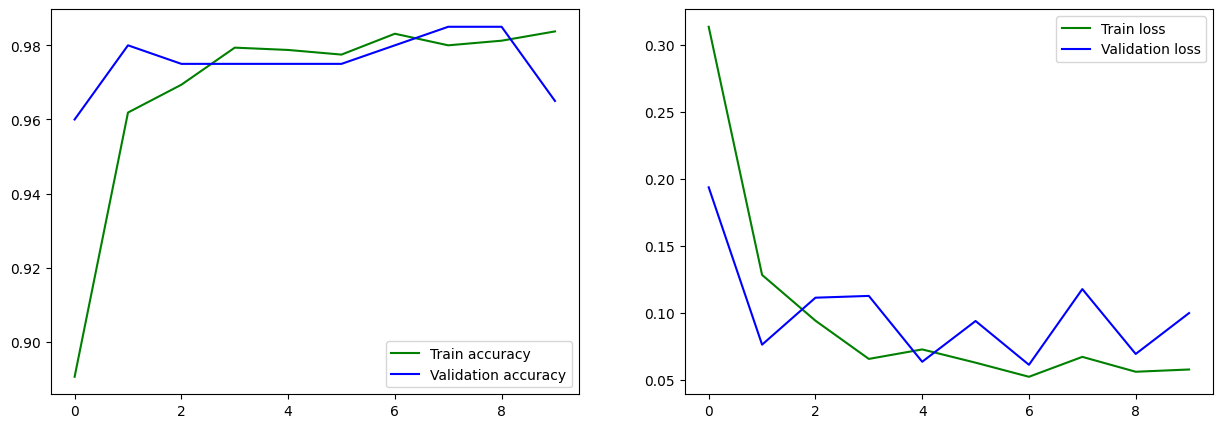

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=144, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [15]:
training(10, 100, 0.005)
model.apply(weight_reset)

Epoch : 1, train accuracy : 0.8856251239776611, train loss : 0.2747858166694641
Epoch : 1, val_accuracy : 0.9700000286102295, val_loss : 0.1606197953224182
Epoch : 2, train accuracy : 0.9675000905990601, train loss : 0.10033788532018661
Epoch : 2, val_accuracy : 0.9800000190734863, val_loss : 0.06602121889591217
Epoch : 3, train accuracy : 0.9668749570846558, train loss : 0.1011609360575676
Epoch : 3, val_accuracy : 0.9800000190734863, val_loss : 0.09336361289024353
Epoch : 4, train accuracy : 0.9743750095367432, train loss : 0.07412786781787872
Epoch : 4, val_accuracy : 0.9650000333786011, val_loss : 0.09995000064373016
Epoch : 5, train accuracy : 0.9775000214576721, train loss : 0.08203830569982529
Epoch : 5, val_accuracy : 0.9650000333786011, val_loss : 0.119940385222435
Epoch : 6, train accuracy : 0.9668750166893005, train loss : 0.08995819836854935
Epoch : 6, val_accuracy : 0.9750000238418579, val_loss : 0.12807592749595642
Epoch : 7, train accuracy : 0.9737499952316284, train los

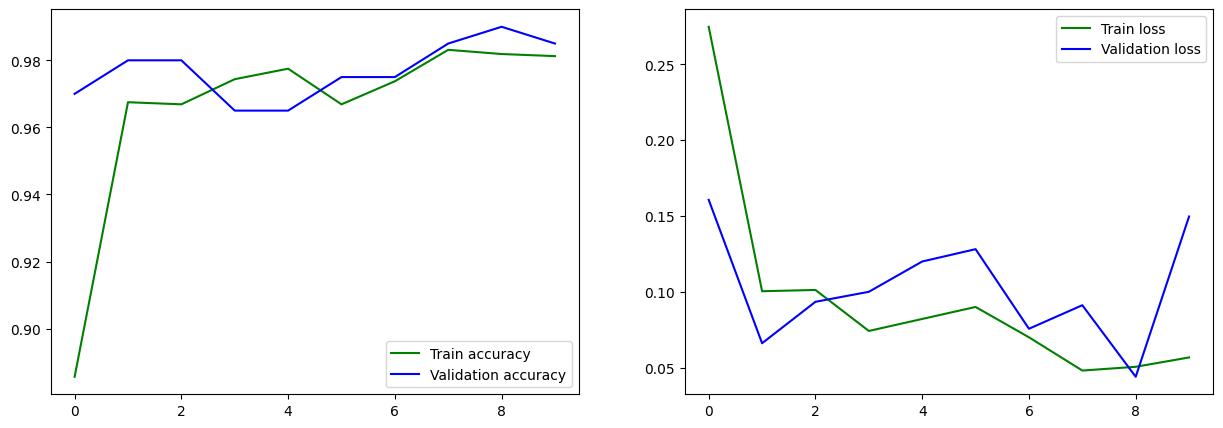

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=144, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [16]:
training(10, 100, 0.007)
model.apply(weight_reset)

Epoch : 1, train accuracy : 0.8043749928474426, train loss : 0.4962158203125
Epoch : 1, val_accuracy : 0.9100000262260437, val_loss : 0.353723406791687
Epoch : 2, train accuracy : 0.9181250333786011, train loss : 0.2576805055141449
Epoch : 2, val_accuracy : 0.9350000023841858, val_loss : 0.2050546258687973
Epoch : 3, train accuracy : 0.9443750381469727, train loss : 0.15839999914169312
Epoch : 3, val_accuracy : 0.9649999737739563, val_loss : 0.14378711581230164
Epoch : 4, train accuracy : 0.953125, train loss : 0.12477512657642365
Epoch : 4, val_accuracy : 0.9700000286102295, val_loss : 0.13257591426372528
Epoch : 5, train accuracy : 0.9662500619888306, train loss : 0.09771295636892319
Epoch : 5, val_accuracy : 0.9649999737739563, val_loss : 0.13325104117393494
Epoch : 6, train accuracy : 0.9674999713897705, train loss : 0.09125205874443054
Epoch : 6, val_accuracy : 0.9800000190734863, val_loss : 0.10800144821405411
Epoch : 7, train accuracy : 0.9781249761581421, train loss : 0.0742935

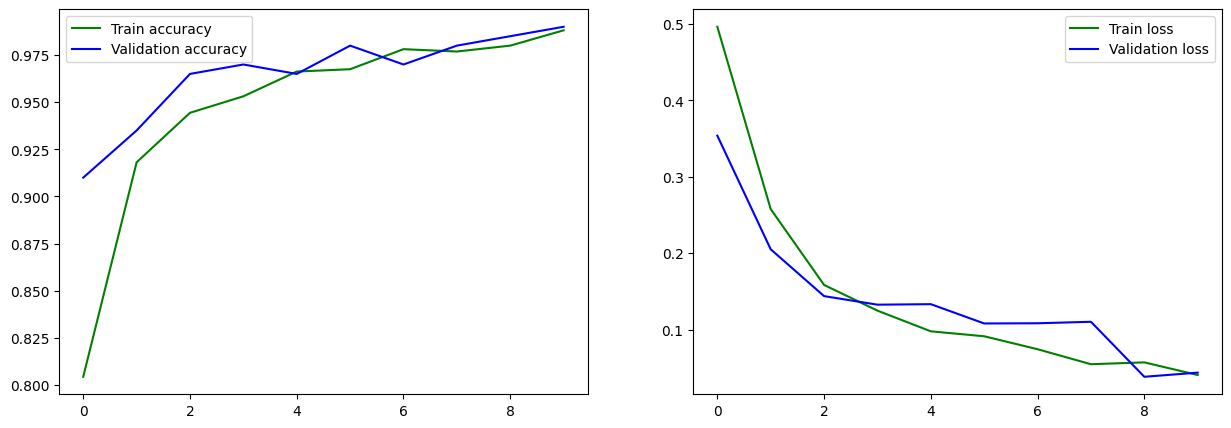

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=144, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [17]:
training(10, 200, 0.001)
model.apply(weight_reset)

Epoch : 1, train accuracy : 0.8668749332427979, train loss : 0.340093731880188
Epoch : 1, val_accuracy : 0.9599999785423279, val_loss : 0.1813690960407257
Epoch : 2, train accuracy : 0.9631250500679016, train loss : 0.1404048204421997
Epoch : 2, val_accuracy : 0.9549999833106995, val_loss : 0.18218863010406494
Epoch : 3, train accuracy : 0.9606250524520874, train loss : 0.11602642387151718
Epoch : 3, val_accuracy : 0.9649999737739563, val_loss : 0.12872646749019623
Epoch : 4, train accuracy : 0.96812504529953, train loss : 0.09490503370761871
Epoch : 4, val_accuracy : 0.9750000238418579, val_loss : 0.10646066069602966
Epoch : 5, train accuracy : 0.9775000810623169, train loss : 0.0656970739364624
Epoch : 5, val_accuracy : 0.9750000238418579, val_loss : 0.08626405894756317
Epoch : 6, train accuracy : 0.9806250333786011, train loss : 0.06375285983085632
Epoch : 6, val_accuracy : 0.9750000238418579, val_loss : 0.11350012570619583
Epoch : 7, train accuracy : 0.9750000238418579, train loss 

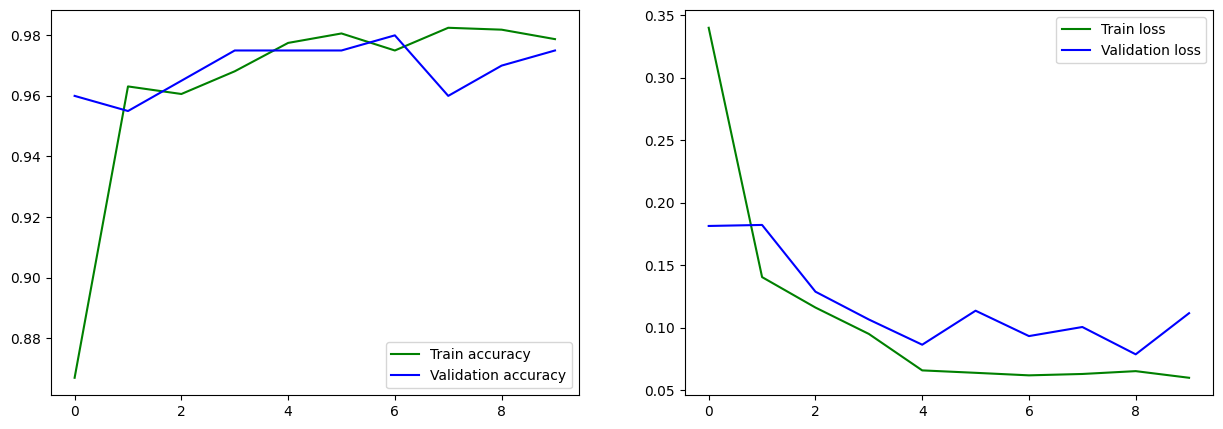

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=144, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [18]:
training(10, 200, 0.005)
model.apply(weight_reset)

Epoch : 1, train accuracy : 0.8781249523162842, train loss : 0.28835833072662354
Epoch : 1, val_accuracy : 0.9700000286102295, val_loss : 0.12956371903419495
Epoch : 2, train accuracy : 0.9743750095367432, train loss : 0.07604720443487167
Epoch : 2, val_accuracy : 0.9700000286102295, val_loss : 0.1464882493019104
Epoch : 3, train accuracy : 0.9737499356269836, train loss : 0.0817798525094986
Epoch : 3, val_accuracy : 0.9850000143051147, val_loss : 0.10954142361879349
Epoch : 4, train accuracy : 0.9768750667572021, train loss : 0.060526780784130096
Epoch : 4, val_accuracy : 0.9800000190734863, val_loss : 0.10197789967060089
Epoch : 5, train accuracy : 0.9800000786781311, train loss : 0.06974893808364868
Epoch : 5, val_accuracy : 0.9599999785423279, val_loss : 0.13971847295761108
Epoch : 6, train accuracy : 0.9831250309944153, train loss : 0.057077422738075256
Epoch : 6, val_accuracy : 0.9750000238418579, val_loss : 0.09064837545156479
Epoch : 7, train accuracy : 0.981249988079071, train

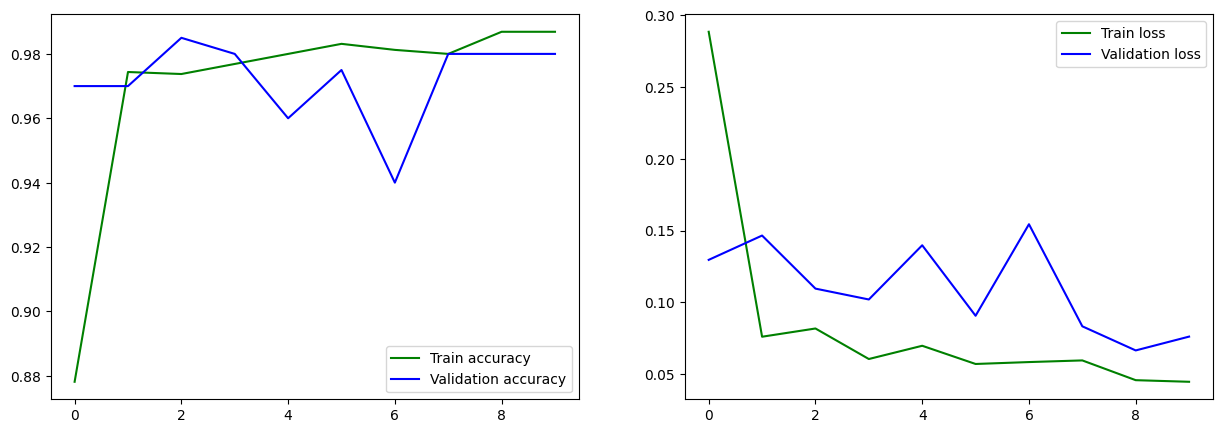

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=144, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [19]:
training(10, 200, 0.007)
model.apply(weight_reset)

Epoch : 1, train accuracy : 0.6233333349227905, train loss : 0.5514016151428223
Epoch : 1, val_accuracy : 0.8349999785423279, val_loss : 0.46938514709472656
Epoch : 2, train accuracy : 0.9122222065925598, train loss : 0.38738566637039185
Epoch : 2, val_accuracy : 0.925000011920929, val_loss : 0.3965470790863037
Epoch : 3, train accuracy : 0.945555567741394, train loss : 0.31290683150291443
Epoch : 3, val_accuracy : 0.9549999833106995, val_loss : 0.32958728075027466
Epoch : 4, train accuracy : 0.9605555534362793, train loss : 0.24224220216274261
Epoch : 4, val_accuracy : 0.9449999928474426, val_loss : 0.24978826940059662
Epoch : 5, train accuracy : 0.9655555486679077, train loss : 0.17002969980239868
Epoch : 5, val_accuracy : 0.9649999737739563, val_loss : 0.18599987030029297
Epoch : 6, train accuracy : 0.9661111235618591, train loss : 0.13109087944030762
Epoch : 6, val_accuracy : 0.9649999737739563, val_loss : 0.14305296540260315
Epoch : 7, train accuracy : 0.9705555438995361, train lo

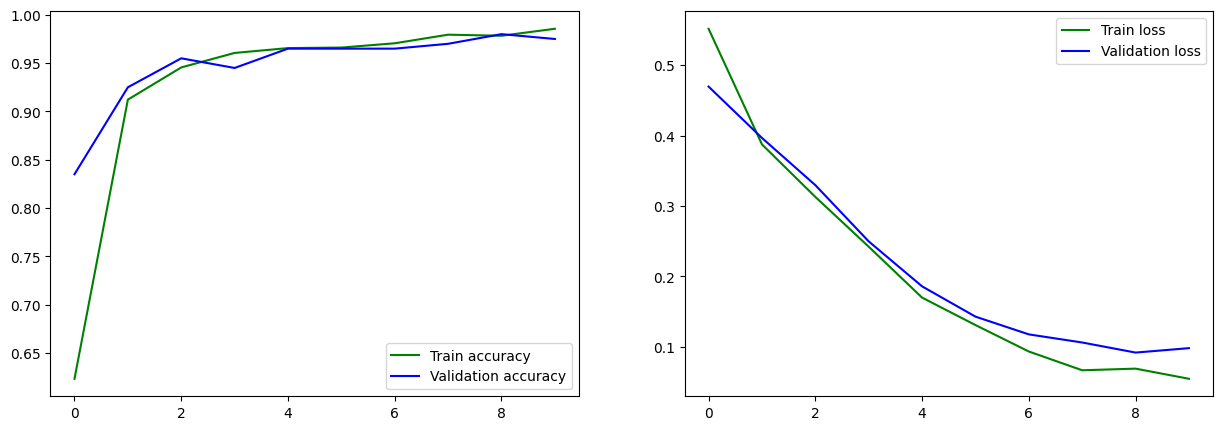

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=144, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [20]:
training(10, 300, 0.001)
model.apply(weight_reset)

Epoch : 1, train accuracy : 0.7761111259460449, train loss : 0.42409127950668335
Epoch : 1, val_accuracy : 0.949999988079071, val_loss : 0.24199388921260834
Epoch : 2, train accuracy : 0.9561111330986023, train loss : 0.1326625496149063
Epoch : 2, val_accuracy : 0.9750000238418579, val_loss : 0.09698370844125748
Epoch : 3, train accuracy : 0.9733334183692932, train loss : 0.08012165874242783
Epoch : 3, val_accuracy : 0.9649999737739563, val_loss : 0.11986609548330307
Epoch : 4, train accuracy : 0.9794445037841797, train loss : 0.06776922941207886
Epoch : 4, val_accuracy : 0.9800000190734863, val_loss : 0.08904913067817688
Epoch : 5, train accuracy : 0.9744444489479065, train loss : 0.08549422770738602
Epoch : 5, val_accuracy : 0.9800000190734863, val_loss : 0.10421881824731827
Epoch : 6, train accuracy : 0.9766666889190674, train loss : 0.07411587238311768
Epoch : 6, val_accuracy : 0.949999988079071, val_loss : 0.17263080179691315
Epoch : 7, train accuracy : 0.9838889241218567, train l

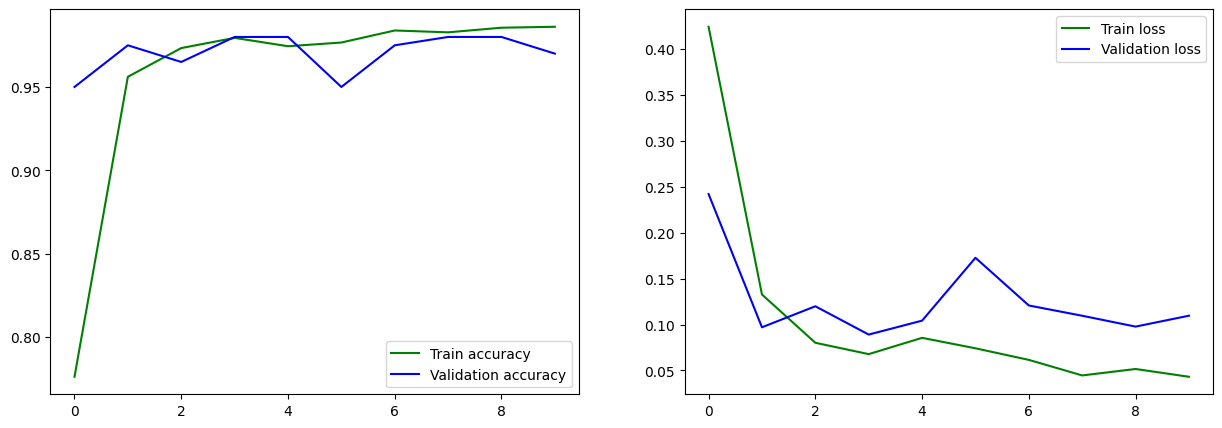

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=144, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [21]:
training(10, 300, 0.005)
model.apply(weight_reset)

Epoch : 1, train accuracy : 0.9327778220176697, train loss : 0.20781461894512177
Epoch : 1, val_accuracy : 0.9649999737739563, val_loss : 0.15729357302188873
Epoch : 2, train accuracy : 0.963888943195343, train loss : 0.12783432006835938
Epoch : 2, val_accuracy : 0.9750000238418579, val_loss : 0.14196640253067017
Epoch : 3, train accuracy : 0.9700000286102295, train loss : 0.09910555928945541
Epoch : 3, val_accuracy : 0.9800000190734863, val_loss : 0.10501527786254883
Epoch : 4, train accuracy : 0.9738888740539551, train loss : 0.09181216359138489
Epoch : 4, val_accuracy : 0.9700000286102295, val_loss : 0.11395202577114105
Epoch : 5, train accuracy : 0.9766666889190674, train loss : 0.0771963968873024
Epoch : 5, val_accuracy : 0.9750000238418579, val_loss : 0.08992180228233337
Epoch : 6, train accuracy : 0.9794445037841797, train loss : 0.07318394631147385
Epoch : 6, val_accuracy : 0.9850000143051147, val_loss : 0.05245956405997276
Epoch : 7, train accuracy : 0.976111114025116, train l

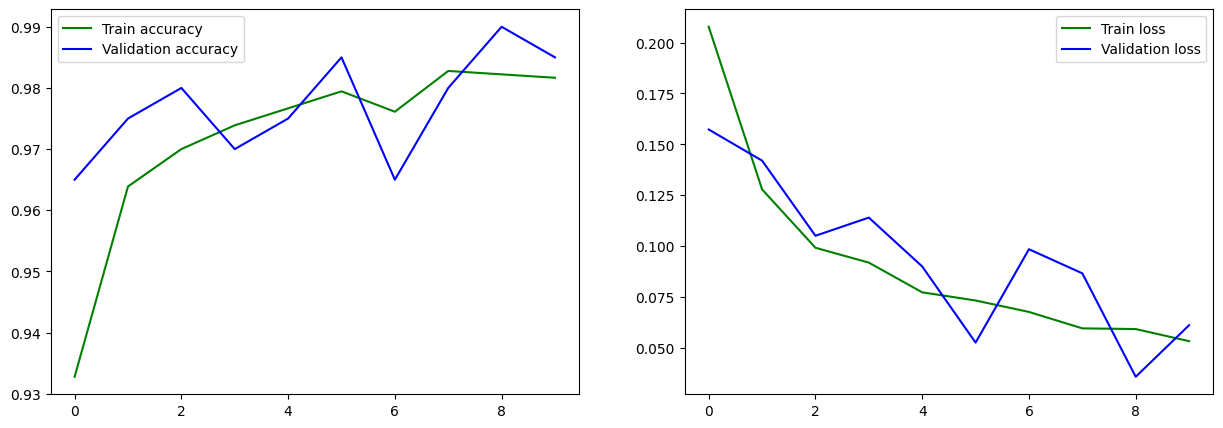

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=144, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [22]:
training(10, 300, 0.007)
model.apply(weight_reset)

Сохраняем результаты в csv

In [23]:
bear_probs = []
model.eval()
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=100, shuffle=False
)
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        bear_probs += list(zip(list(fileid), preds_list))
bear_probs.sort(key=lambda x: int(x[0]))
bear_probs[:10]

[(tensor(0), 0.24880415201187134),
 (tensor(0), 0.25467556715011597),
 (tensor(0), 0.25706747174263),
 (tensor(0), 0.25974440574645996),
 (tensor(0), 0.2593451142311096),
 (tensor(0), 0.2582246959209442),
 (tensor(0), 0.2511306703090668),
 (tensor(0), 0.2503919303417206),
 (tensor(0), 0.25764548778533936),
 (tensor(0), 0.2500213086605072)]

In [24]:
idx = list(i for i in range(len(bear_probs)))
prob = list(map(lambda x: x[1], bear_probs))

In [25]:
submission = pd.DataFrame({'id':idx,'label':prob})
submission.to_csv('final.csv',index=False)
submission

,id,label
0,0,0.248804
1,1,0.254676
2,2,0.257067
3,3,0.259744
4,4,0.259345
...,...,...
195,195,0.251349
196,196,0.251162
197,197,0.256677
198,198,0.256521


Сохраняем модель

In [26]:
torch.save(model.state_dict(), os.path.join("K:\Pyth\PLab1\Lab5", "model_weight.pt"))

Инициализируем модель по новой

In [27]:
mymodel = CNN()
mymodel.load_state_dict(torch.load(os.path.join("K:\Pyth\PLab1\Lab5", "model_weight.pt")))

<All keys matched successfully>

Запуск модели

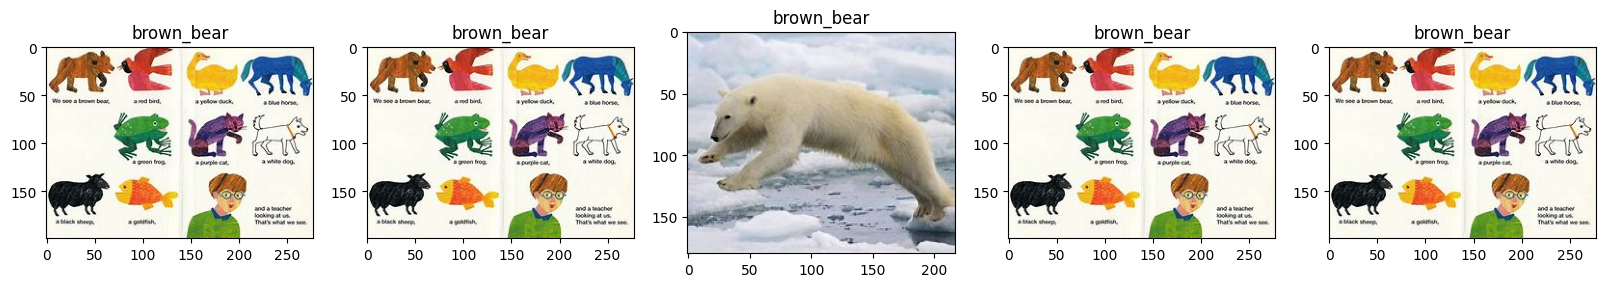

In [39]:
id_list = []
class_ = {0: 'brown_bear', 1: 'polar_bear'}

fig, axes = plt.subplots(1, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = train_list[i]
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)